### ReAct Agent Architecture Chatbot

In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import  StateGraph, START, END
from langgraph.graph.message import add_messages ## work add the msg appeneded to the state

In [2]:
## state
class State(TypedDict):
    # Msg have type list defines how this state key should be updated

    messages : Annotated[list, add_messages] ## appended to the list

graph_bilder =StateGraph(State)

graph_bilder

In [11]:
## Building the graph

import os
from dotenv import load_dotenv
load_dotenv()


True

In [4]:
from langchain_groq import  ChatGroq
from langchain.chat_models import init_chat_model

llm =ChatGroq(model="openai/gpt-oss-20b")

In [5]:
## node Chatbot

def chatbot(state:State):
    return {"messages": [llm.invoke(state['messages'])]}

In [ ]:
# from langchain_community.tools import BraveSearch

In [ ]:
from langchain_tavily import TavilySearch

tool =TavilySearch(max_results=2)
## Testing 
tool.invoke("What is Langgraph?")

{'query': 'What is Langgraph?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.langchain.com/langgraph',
   'title': 'LangGraph',
   'content': "Design agent-driven user experiences with LangGraph Platform's APIs. Quickly deploy and scale your application with infrastructure built for agents. LangGraph sets the foundation for how we can build and scale AI workloads — from conversational agents, complex task automation, to custom LLM-backed experiences that 'just work'. The next chapter in building complex production-ready features with LLMs is agentic, and with LangGraph and LangSmith, LangChain delivers an out-of-the-box solution to iterate quickly, debug immediately, and scale effortlessly.” LangGraph sets the foundation for how we can build and scale AI workloads — from conversational agents, complex task automation, to custom LLM-backed experiences that 'just work'. LangGraph Platform is a service for deploying and scaling LangGraph 

In [12]:
def multiply(a : int, b:int)-> int:
    """ 
    Multiply a and b
    Args:
        a first int
        b seoncd int
    return: 
        int output
    """
    return a*b

In [13]:
tools =[tool, multiply]
llm_with_tools = llm.bind_tools(tools)

llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001BA679F27B0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001BA679F34D0>, model_name='openai/gpt-oss-20b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A l

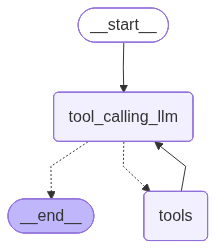

In [20]:
## Stategraph for llm with tool

from langgraph.prebuilt import ToolNode, tools_condition


def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}


# Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm) ## need to add the name and the definition of the node
builder.add_node("tools", ToolNode(tools))


# edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition

)

## change is here giving feedback here

builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile()

# visualize

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass



In [21]:
## Multiplication part
response= graph.invoke({"messages": "give me the latest sora news then What 2*3.3 then add 10"})
response["messages"][-1].content
for m in response["messages"]:
    m.pretty_print()

## here you can see tool call happened but only 1st one happened, not the multiply. 

================================ Human Message =================================

give me the latest sora news then What 2*3.3 then add 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_3eee5348-2c48-41bc-9169-e216998d6864)
 Call ID: fc_3eee5348-2c48-41bc-9169-e216998d6864
  Args:
    query: Sora news
    search_depth: advanced
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "Sora news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.nbcnews.com/tech/tech-news/openai-announces-sora-2-ai-video-audio-app-rcna234753", "title": "ChatGPT parent company OpenAI announces Sora 2 with AI video app - NBC News", "score": 0.7065353, "published_date": "Tue, 30 Sep 2025 19:40:04 GMT", "content": "The next generation of OpenAI's video generator is here.\n\nSora 2, the company's latest video an

In [24]:
response= graph.invoke({"messages": "Hello My name is Souvick."})
response["messages"][-1].content
for m in response["messages"]:
    m.pretty_print()


================================ Human Message =================================

Hello My name is Souvick.
================================== Ai Message ==================================

Hello Souvick! 👋 How can I help you today?
